In [2]:
###
### LIBRARIES
###

import load_data

import os
import pandas as pd
import numpy as np
import datetime as dt

# matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors 

#seaborn
import seaborn as sns

# same as ggplot2 in R
from plotnine import *

# geographical plots
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pysal.viz.mapclassify as mc


In [3]:
###
### FUNCTIONS
###

def compute_daily_trend(df, variable):
    
    """
    This function computes daily increment, using the cumulative value as (value[i+1] - value[i])
    """
     
    n = df.shape[0]

    aux = []

    for i in range(n):
        
        if i==0:
            aux.append(df[variable][i])
        else:
            region1 = df['denominazione_regione'][i-1]
            region2 = df['denominazione_regione'][i]
            if region1 != region2:
                aux.append(df[variable][i])
            else: 
                total1 = df[variable][i]
                total2 = df[variable][i-1]
                aux.append(total1 - total2)

    return aux

def plot_by_region(df, region):
    
    """
    This function shows two plots:
        - time series of total cases, total recovered and total deaths for the specific region in input
        - time series of daily increment of new cases, new recovered and new deaths for the specific region in input
    """
    
    total_cases = df[df['denominazione_regione'] == region]['totale_casi']
    total_recovered = df[df['denominazione_regione'] == region]['dimessi_guariti']
    total_deaths = df[df['denominazione_regione'] == region]['deceduti']
    
    increment_cases = df[df['denominazione_regione'] == region]['nuovi_positivi']
    increment_recovered = df[df['denominazione_regione'] == region]['nuovi_dimessi']
    increment_deaths = df[df['denominazione_regione'] == region]['nuovi_deceduti']
    
    # format date axis
    dates = df[df['denominazione_regione'] == region]['date']
    dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
    
    fig, ax = plt.subplots(nrows=2,ncols=1, sharex=True,figsize=(12, 10))
    
    # gives an interval locator in days
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    ax[0].plot(dates,total_cases,'-o', label = 'Total Cases')
    ax[0].plot(dates,total_deaths,'-o', label = 'Total Deaths')
    ax[0].plot(dates,total_recovered,'-o', label = 'Total Recoveredd')
    
    # position legend
    ax[0].legend(loc='upper left')
    
    # gives an interval locator in days
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    ax[1].plot(dates,increment_cases,'-o', label = 'Increment Cases')
    ax[1].plot(dates,increment_deaths,'-o', label = 'Increment Deaths')
    ax[1].plot(dates,increment_recovered,'-o', label = 'Increment Recoveredd')
    ax[1].legend(loc='upper left')
    
    fig.autofmt_xdate()
    fig.suptitle('{}'.format(region))
    plt.show()


def pie_chart(df, region):
    
    """
    This function plots a pie chart of subdivision of positive cases in a specific region
    """
    
    # Data to plot
    labels = ['recoverev with symptoms','intensive care','home isolation']
    sizes = df[df['denominazione_regione']==region][labels]
    colors = ['gold', 'yellowgreen', 'lightcoral']
    explode = (0, 0, 0)  # explode 1st slice

    # Plot
    p, tx, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="", shadow=True,
                               startangle=140)
    for i, a in enumerate(autotexts):
        perc = round((sizes.iloc[0,i]/np.array(sizes.sum(axis=1))[0]),3)*100
        a.set_text("{} ({}%)".format(sizes.iloc[0,i], perc))
    
    plt.title('Subdivision in {}'.format(region))
    plt.axis('equal')
    plt.show()
    
def geodata_plot_regions(italy, geo_df, variable):
    
    """
    This function shows a geographic plot of a specific variable distribution (total cases and so on) by region:
    - italy: geodataframe of italy regions 
    - geo_df: geodataframe of Covid-19 data
    """
    
    geo_df_aggregated = geo_df.groupby('id_regione')[variable].sum().reset_index()
    italy_merged = pd.merge(italy, geo_df_aggregated, how='inner', left_on='ID_1', right_on='id_regione')
    
    fig, ax = plt.subplots(figsize=(12, 10))
    italy_merged.plot(column=variable, legend = True, ax=ax)

    plt.title('{}'.format(variable))
    
    
def geodata_plot_provinces(italy, geo_df, region, variable, k=5):
    
    """
    This function shows a geographic plot of a specific region and its provinces.
    - italy: geodataframe of italy provinces 
    - geo_df: geodataframe of Covid-19 data
    """
    
    if region == 'All':
        geo_df = geo_df[['id_provincia',variable]]
        italy_merged = pd.merge(italy, geo_df, how='left', left_on='ID_2', right_on='id_provincia')
    else: 
        geo_df = geo_df[['id_provincia',variable]]
        italy = italy[italy['NAME_1']==region]
        italy_merged = pd.merge(italy, geo_df, how='left', left_on='ID_2', right_on='id_provincia')
    
    if italy_merged[variable].isna().any():
        nan_exists = True
    else:
        nan_exists = False

    
    # defining quantiles based to k as input
    quantiles = mc.Quantiles(italy_merged.totale_casi.dropna(), k=k)
    variable_cat = variable + '_cat'
    italy_merged[variable_cat] = quantiles.find_bin(italy_merged.totale_casi).astype('str')
    italy_merged.loc[italy_merged.totale_casi.isnull(), variable_cat] = 'No Data'

    cmap = plt.cm.get_cmap('Blues', k)
    cmap_list = [colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
    cmap_final = colors.ListedColormap(cmap_list)

    if nan_exists:
        cmap_list.append('grey')
        cmap_final = colors.ListedColormap(cmap_list)

    # plot map
    fig, ax = plt.subplots(figsize=(12, 10))
    italy_merged.plot(column=variable_cat, edgecolor='k', cmap=cmap_final,
             legend=True, legend_kwds=dict(loc='upper left'),
             ax=ax)

    # get all upper bounds in the quantiles category
    upper_bounds = quantiles.bins
    # get and format all bounds
    bounds = []
    for index, upper_bound in enumerate(upper_bounds):
        if index == 0:
            lower_bound = italy_merged.totale_casi.min()
        else:
            lower_bound = upper_bounds[index-1]

        bound = f'{lower_bound:.2f} - {upper_bound:.2f}'
        bounds.append(bound)

    # get all the legend labels
    leg = ax.get_legend()
    legend_labels = leg.get_texts()
    # replace the numerical legend labels
    for bound, legend_label in zip(bounds, legend_labels):
        legend_label.set_text(bound)
    
    # position legend outside
    leg.set_bbox_to_anchor((1.05, 1.0))
    # call it to not cut the legend and to fit correctly the plot
    plt.tight_layout()
    plt.title('{}: {}'.format(region,variable))


In [4]:
###
### DIRECTORIES
###

PROJECT_DIR = os.getcwd()
DATA_DIR = os.path.join(os.path.dirname(PROJECT_DIR),'Data')
SHAPEFILES_DIR = os.path.join(os.path.dirname(PROJECT_DIR),'Shapefiles')
# RESULTS_DIR = os.path.join(os.path.dirname(PROJECT_DIR),'Results')

In [5]:
###
### LOADING DATA
###

### 1) Covid_Data: if anything is specified, loads data using url github to repository.
###                if a DATA_DIR is specified, loads data downloaded as csv
data_provinces, data_regions, data_national = load_data.load_covid_data()

### 2) Shapefiles: if anything is specified, loads data using url github to repository.
###                if a DATA_DIR is specified, loads data downloaded as csv
italy_provinces, italy_regions = load_data.load_shapefiles(SHAPEFILES_DIR)

# data wrangling
data_regions = data_regions.sort_values(['denominazione_regione','data'])
data_regions = data_regions.reset_index()

In [6]:
###
### FEATURE ENGINEERING
### 

# 2) REGIONE
# Colonne:
# 1. data: timestamp
# 2. stato: sigla stato italiano
# 3. codice_regione: numero codice regione
# 4. denominazione_regione: nome della regione
# 5-6. lat e long: coordinate
# 7. ricoverati_con_sintomi: totale del numero di ricoverati 
# 8. terapia_intensiva: totale del numero di pazienti in terapia intensiva
# 9. totale_ospedalizzati: somma di 7 + 8
# 10. isolamento_domiciliare: totale del numero di isolati
# 11. totale_attualmente_positivi: totale del numero di contagiati 
# 12. nuovi_attualmente_positivi: numero di nuovi positivi in quel giorno
# 13. dimessi_guariti: totale dei dimessi guariti 
# 14. deceduti: totale dei deceduti
# 15. totale_casi: totale di 11 + 13 + 14
# 15. tamponi: totale dei tamponi


# 1) Calcolo variabili giornaliere: (i+1 - i)
new_dimessi = compute_daily_trend(data_regions, 'dimessi_guariti')
new_deceduti = compute_daily_trend(data_regions, 'deceduti')
new_tamponi = compute_daily_trend(data_regions, 'tamponi')

data_regions['nuovi_dimessi'] = new_dimessi
data_regions['nuovi_deceduti'] = new_deceduti
data_regions['nuovi_tamponi'] = new_tamponi

# 2) calcolo anno, mese e giorno da campo data:
data_regions['date'] = data_regions['data'].apply(lambda x: x[:10])
data_regions['Anno'] = data_regions['date'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").year)
data_regions['Mese'] = data_regions['date'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").month)
data_regions['Giorno'] = data_regions['date'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").day)
#dati_regioni = dati_regioni.drop(columns='date')


# Salvare nuovo csv
# data_regions.to_csv(os.path.join(RESULTS_DIR,'regions.csv'))


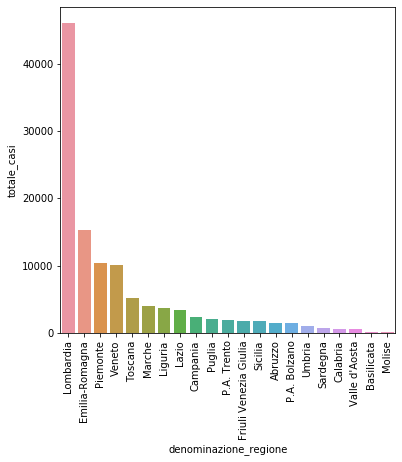

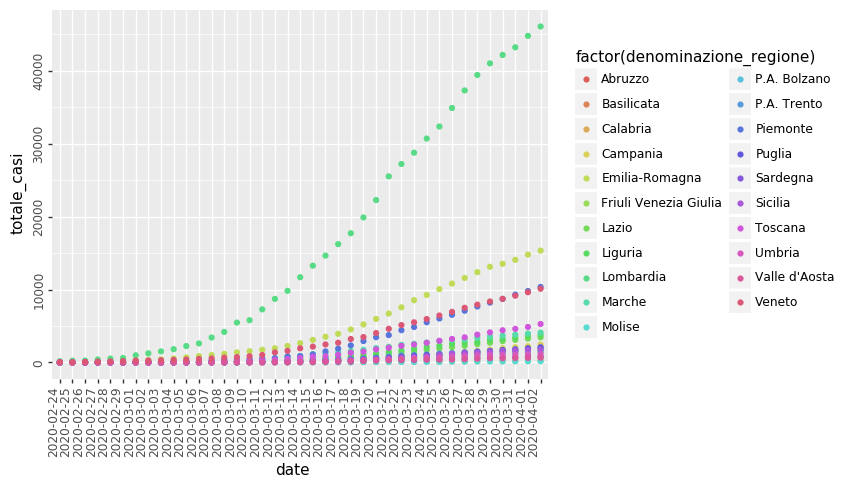

<ggplot: (5940550)>

In [7]:
###
### EXPLORATORY DATA ANALYSIS - TOTAL VIEW
### 

# totale regioni

totale_regioni = data_regions.groupby('denominazione_regione')['totale_casi'].max().to_frame('totale_casi').reset_index()
totale_regioni = totale_regioni.sort_values('totale_casi', ascending = False)


### bar charts totale casi

# 1) ggplot
(ggplot(totale_regioni)) +\
   geom_col(aes(x='denominazione_regione',y='totale_casi')) + theme(axis_text=element_text(angle = 90, hjust = 1))

# 2) seaborn
plt.figure(figsize=(6,6))
ax = sns.barplot(x="denominazione_regione", y="totale_casi", data=totale_regioni)#, palette=sns.color_palette("GnBu", 10))
plt.xticks(rotation='vertical')
plt.show()

### evoluzione totale casi per regione
(ggplot(data_regions) +\
   geom_point(aes(x='date',y='totale_casi', color = 'factor(denominazione_regione)')) +\
theme(axis_text=element_text(angle = 90, hjust = 1)))



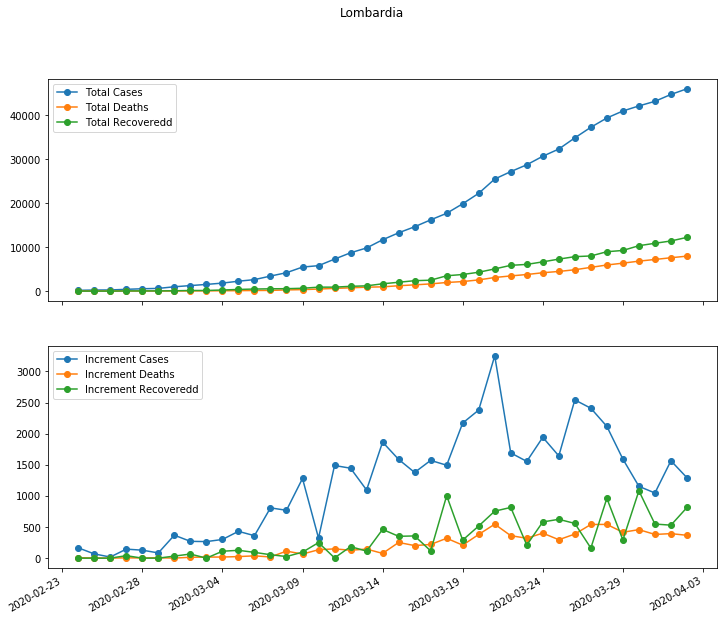

In [8]:
###
### EXPLORATORY DATA ANALYSIS - BY REGION
### 

# totals & increments
plot_by_region(data_regions, 'Lombardia')

# pie chart
# totale_regioni_2 = data_regions.groupby('denominazione_regione')\
# [['ricoverati_con_sintomi','terapia_intensiva','isolamento_domiciliare']].max().reset_index()
# pie_chart(totale_regioni_2,'Marche')



In [14]:
###
### EXPLORATORY DATA ANALYSIS - Geographic Plots
### 

### dictionaries
_, dictionary_regions, dictionary_provinces = load_data.dictionary_creation()

### 1) REGIONS
# We need to build a geodataframe for Covid-19 data: it needs a shapely object 
# from the lat and long of the regions in our dataset...
# ATT: We should always verify the crs (coordinate reference system)
df_aggregated_regions = data_regions.groupby('denominazione_regione')\
[['lat','long','totale_casi','deceduti','dimessi_guariti']].max().reset_index()
geometry_regions = [Point(xy) for xy in zip(df_aggregated_regions['long'],df_aggregated_regions['lat'])]

# ...we feed now the geodataframe
geo_df_regions = gpd.GeoDataFrame(df_aggregated_regions,  geometry = geometry_regions)

# dictionaries of regions id in order to map with shape file of italy regions
geo_df_regions['id_regione'] = geo_df_regions['denominazione_regione'].map(dictionary_regions)



### 2) PROVINCES

# We need to build a geodataframe for Covid-19 data: it needs a shapely object 
# from the lat and long of the regions in our dataset...
# ATT: We should always verify the crs (coordinate reference system)
df_aggregated_provinces = data_provinces.groupby(['denominazione_regione','denominazione_provincia'])[['totale_casi','lat','long']]\
.max().reset_index()
geometry_provinces = [Point(xy) for xy in zip(df_aggregated_provinces['long'],df_aggregated_provinces['lat'])]

# ...we feed now the geodataframe
geo_df_provinces = gpd.GeoDataFrame(df_aggregated_provinces,  geometry = geometry_provinces)

# dictionaries of provinces id in order to map with shape file of italy provinces
geo_df_provinces['id_provincia'] = geo_df_provinces['denominazione_provincia'].map(dictionary_provinces)

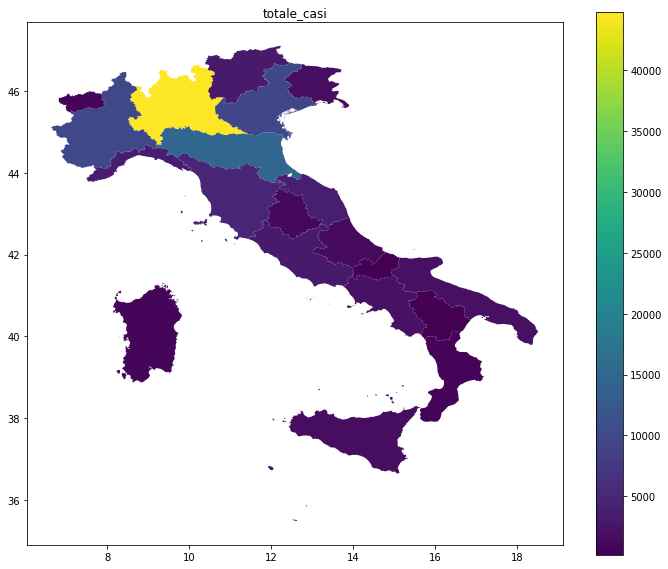

In [15]:
###
### EXPLORATORY DATA ANALYSIS - Geographic Plots
### 

# geographic plot of all regions
geodata_plot_regions(italy_regions, geo_df_regions, 'totale_casi')



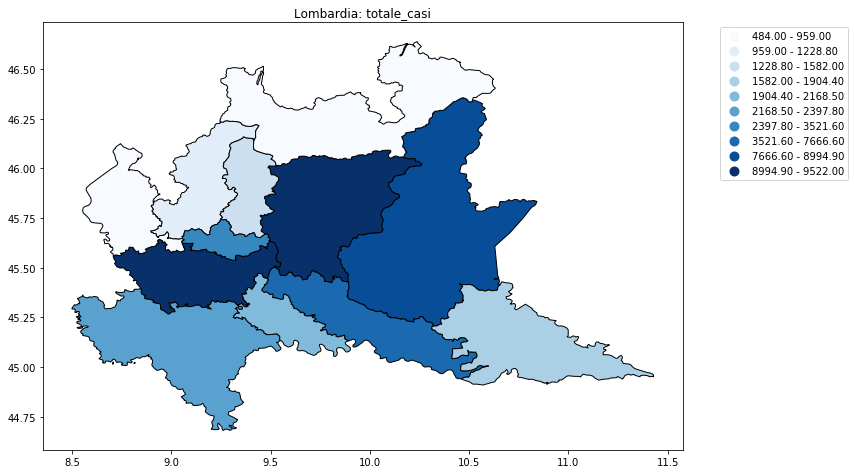

In [16]:
###
### EXPLORATORY DATA ANALYSIS - Geographic Plots
### 

# geogrpahic plot of specific region with its provinces
geodata_plot_provinces(italy_provinces,geo_df_provinces,'Lombardia','totale_casi', k= 10)